In [1]:
import sys
print(sys.executable)

d:\03_keiba\env\Scripts\python.exe


In [2]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', 100)
DATA_DIR = '/pickle'

tyoukyou = pd.read_pickle('race_info.pickle')
horse_jockey = pd.read_pickle(DATA_DIR +'/new_results__horse_jockey_2022.pickle')
peds = pd.read_pickle(DATA_DIR +'/peds.pickle')
peds = peds.fillna('不明')

for column in peds.columns:
    le = LabelEncoder()
    peds[column] = le.fit_transform(peds[column])

df1 = pd.read_pickle('new_results_2022.pickle')
df2 = pd.read_pickle('new_results_detail_2022.pickle')
df3 = pd.read_pickle('new_results__horse_jockey_2022.pickle')
df4 = pd.read_pickle('horse_id_list.pickle')
df = pd.concat([df1,df2,df3],axis=1)
df = df.merge(df4, on='horse_id')

In [3]:
jockey = df[['騎手', 'jockey_id']]
jockey = jockey[jockey['jockey_id'].duplicated() == False]
tyoukyou = pd.merge(tyoukyou, jockey, on='騎手')

tyoukyou = tyoukyou.drop(['人気', '映像','馬場指数', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '勝ち馬(2着馬)', '賞金', '騎手','R','着差', '着順','ペース', 'オッズ','映像', '上り', '枠番'], axis=1)
tyoukyou = tyoukyou.dropna(subset=['タイム'])
tyoukyou.loc[:, ['コース', '馬場_x', '脚色']] = tyoukyou.loc[:, ['コース', '馬場_x', '脚色']].fillna('調教なし')
tyoukyou.loc[:, ['1C','2C','3C','4C','5C']] = tyoukyou.loc[:, ['1C','2C','3C','4C','5C']].fillna(0)
tyoukyou = tyoukyou[~tyoukyou.距離.str.contains('障')]
tyoukyou = tyoukyou.dropna(subset=['通過'])
tyoukyou = tyoukyou[tyoukyou.通過.str.contains('-')]
tyoukyou = tyoukyou.assign(開催数 = lambda x: (x['開催'].str[0]))
tyoukyou = tyoukyou.assign(開催日付 = lambda x: (x['開催'].str[-1]))
tyoukyou = tyoukyou.assign(開催 = lambda x: (x['開催'].str[1:3]))
tyoukyou = tyoukyou.assign(形態 = lambda x: (x['距離'].str[0]))
tyoukyou = tyoukyou.assign(距離 = lambda x: (x['距離'].str[1:]))
tyoukyou = tyoukyou.assign(コーナー数=lambda x: x['通過'].apply(lambda s: len(str(s).split('-')) if isinstance(s, str) else 0))
tyoukyou = tyoukyou.assign(first = lambda x: (x['通過'].str.split('-').str[0]))
tyoukyou = tyoukyou.assign(second = lambda x: (x['通過'].str.split('-').str[-1]))
tyoukyou = tyoukyou.drop('通過', axis=1)
tyoukyou = tyoukyou.assign(体重 = lambda x: (x['馬体重'].str[:3]))
tyoukyou = tyoukyou.assign(増減=lambda x: x['馬体重'].str[4].apply(lambda s: 'プラス' if s == '+' else 'マイナス' if s == '-' else '変化なし'))
pattern = r"\d+"
tyoukyou = tyoukyou.assign(増減値=lambda x: x['馬体重'].str[4:].apply(lambda s: re.findall(pattern, s)[0]))

df = df.assign(体重 = lambda x: (x['馬体重'].str[:3]))
df = df.assign(増減=lambda x: x['馬体重'].str[4].apply(lambda s: 'プラス' if s == '+' else 'マイナス' if s == '-' else '変化なし'))
def test(x):
    try:
        num = x[4:]
        num  = re.findall(r"\d+", num)[0]
    except:
        num = 0
    return num

df['馬体重'] = df['馬体重'].apply(test)
df['距離'] = df['distance'].apply(lambda x: re.findall(pattern, x)[0])

In [4]:
df = pd.merge(df, tyoukyou, on=['体重', '距離', '馬番', 'jockey_id', 'タイム'])
df = df.drop(['着順', 'タイム','上り','馬名', 'time','騎手', '着差', 'ﾀｲﾑ指数', '通過', '馬体重_x', '調教ﾀｲﾑ', '厩舎ｺﾒﾝﾄ', '馬主', '賞金(万円)', 'deokureNum', 'raceNum', '調教日付', 'distance','天気', '斤量_y', '馬場_y', '馬体重_y', '備考_y', '形態', 'first', 'second', '増減_y'], axis=1)
df = df.rename(columns={'斤量_x': '斤量', '備考_x': '備考', '増減_x': '増減', '馬場_x': '調教馬場', 'コース': '調教コース'})

In [5]:
def remarks(x):
    if x == '出遅れ' or x == '出脚鈍い' or x == '躓く':
        return 1
    return 0

df['target'] = df['備考'].apply(remarks)
df = df.drop('備考', axis=1)

In [6]:
# 性齢を分ける
pattern = r'[\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff]+'
df['歳'] = df['性齢'].apply(lambda x : re.findall(r"\d+", x)[0])
df['性別'] = df['性齢'].apply(lambda x : re.findall(pattern, x)[0])
df = df.drop('性齢', axis=1)

# 10以下の調教師をまとめて、ラベルエンコーディング
counts = df['調教師'].value_counts()
trainers_to_replace = counts[counts <= 10].index
df['調教師'] = df['調教師'].replace(trainers_to_replace, '名もなき調教師')


In [7]:
def setRace(race):
    if 'G1' in race:
        return 'G1'
    elif 'G2' in race:
        return 'G2'
    elif 'G3' in race:
        return 'G3'
    elif 'OP' in race:
        return 'OP'
    elif '(L)' in race:
        return 'L'
    elif '1勝クラス' in race:
        return '1勝クラス'
    elif '3勝クラス' in race:
        return '3勝クラス'
    elif '2勝クラス' in race:
        return '2勝クラス'
    elif '1600万下' in race:
        return 'その他'
    elif '1000万下' in race:
        return 'その他'
    elif '500万下' in race:
        return 'その他'
    elif '葵S(G)' in race:
        return 'その他'

    return race
df['レース名'] = df['レース名'].apply(setRace)

In [8]:
def date_change(x):
    tmp = int(x[5:7])
    if tmp < 4:
        return 0
    elif 4 <= tmp < 7:
        return 1
    elif 7 <= tmp < 10:
        return 2
    return 3
df['日付'] = df['日付'].apply(date_change)

In [9]:
sums = df.groupby('jockey_id')['target'].sum()
counts = df.groupby('jockey_id')['target'].count()
j = pd.DataFrame(sums / counts).reset_index()
df = df.merge(j, on='jockey_id')
df = df.rename(columns={'target_y': 'jockey_deokure_avg', 'target_x' : 'target'})

sums = df.groupby('horse_id')['target'].sum()
counts = df.groupby('horse_id')['target'].count()
h = pd.DataFrame(sums / counts).reset_index()
df = df.merge(h, on='horse_id')
df = df.rename(columns={'target_y': 'horse_deokure_avg','target_x' : 'target'})

In [10]:
df = df[df['調教コース'].map(df['調教コース'].value_counts()) > 12]
df['調教コース'].replace('栗坂', '栗東', inplace=True)
df['調教コース'].replace('南Ｗ', '三浦', inplace=True)
df['調教コース'].replace('南Ｄ', '三浦', inplace=True)
df['調教コース'].replace('ＣＷ', '栗東', inplace=True)
df['調教コース'].replace('函Ｗ', '函館', inplace=True)
df['調教コース'].replace('札ダ', '札幌', inplace=True)
df['調教コース'].replace('美Ｐ', '三浦', inplace=True)
df['調教コース'].replace('美坂', '三浦', inplace=True)
df['調教コース'].replace('小ダ', '小倉', inplace=True)
df['調教コース'].replace('北Ｃ', '三浦', inplace=True)
df['調教コース'].replace('ＤＰ', '栗東', inplace=True)
df['調教コース'].replace('栗Ｂ', '栗東', inplace=True)
df['調教コース'].replace('栗芝', '栗東', inplace=True)
df['調教コース'].replace('栗飛', '栗東', inplace=True)
df['調教コース'].replace('札芝', '札幌', inplace=True)
df['調教コース'].replace('函ダ', '函館', inplace=True)
df['調教コース'].replace('南芝', '三浦', inplace=True)
df['調教コース'].replace('函芝', '函館', inplace=True)
df['調教コース'].replace('南ダ', '三浦', inplace=True)
df['調教コース'].replace('栗Ｅ', '栗東', inplace=True)
df['調教コース'].replace('門坂', '札幌', inplace=True)
df['調教コース'].replace('小障', '小倉', inplace=True)
df['調教コース'].replace('小芝', '小倉', inplace=True)
df['調教コース'].replace('栗障', '栗東', inplace=True)
df['調教コース'].replace('北Ｂ', '三浦', inplace=True)
df['調教コース'].replace('船橋', '三浦', inplace=True)
df['調教コース'].replace('新ダ', '三浦', inplace=True)

In [11]:
import importlib
import create
importlib.reload(create)
result = create.create_shipping_time(df)
df['輸送時間'] = result

In [12]:
def split_tyoukyoushi(x):
    try:
        return x.split(']')[1].strip()
    except:
        return x
df['調教師'] =df['調教師'].apply(split_tyoukyoushi)

In [14]:
import joblib
for column in ['track', 'rightORleft', 'whether', 'situation', '増減', '調教コース', '調教馬場','脚色', '開催', '性別', '調教師', 'レース名']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    joblib.dump(le, f'./label_encoder/{column}.pkl')

In [386]:
# df['単勝'] = df['単勝'].astype(float)
# df['jockey_id'] = df['jockey_id'].astype(int)
# df['距離'] = df['距離'].astype(int)
# df['体重'] = df['体重'].astype(int)
# df['調教コース'] = df['調教コース'].astype(int)
# df['開催数'] = df['開催数'].astype(int)
# df['開催日付'] = df['開催日付'].astype(int)
# df['歳'] = df['歳'].astype(int)
# df['増減値'] = df['増減値'].astype(int)

In [387]:
# df = df.merge(peds, left_on='horse_id', right_index=True)
# df = df.astype(float)

In [15]:
df = df.drop(['人気', '単勝'], axis=1)

In [16]:
df = df.drop(['コーナー数'], axis=1)

In [17]:
df = df.drop(['horse_id', 'jockey_id'], axis=1)

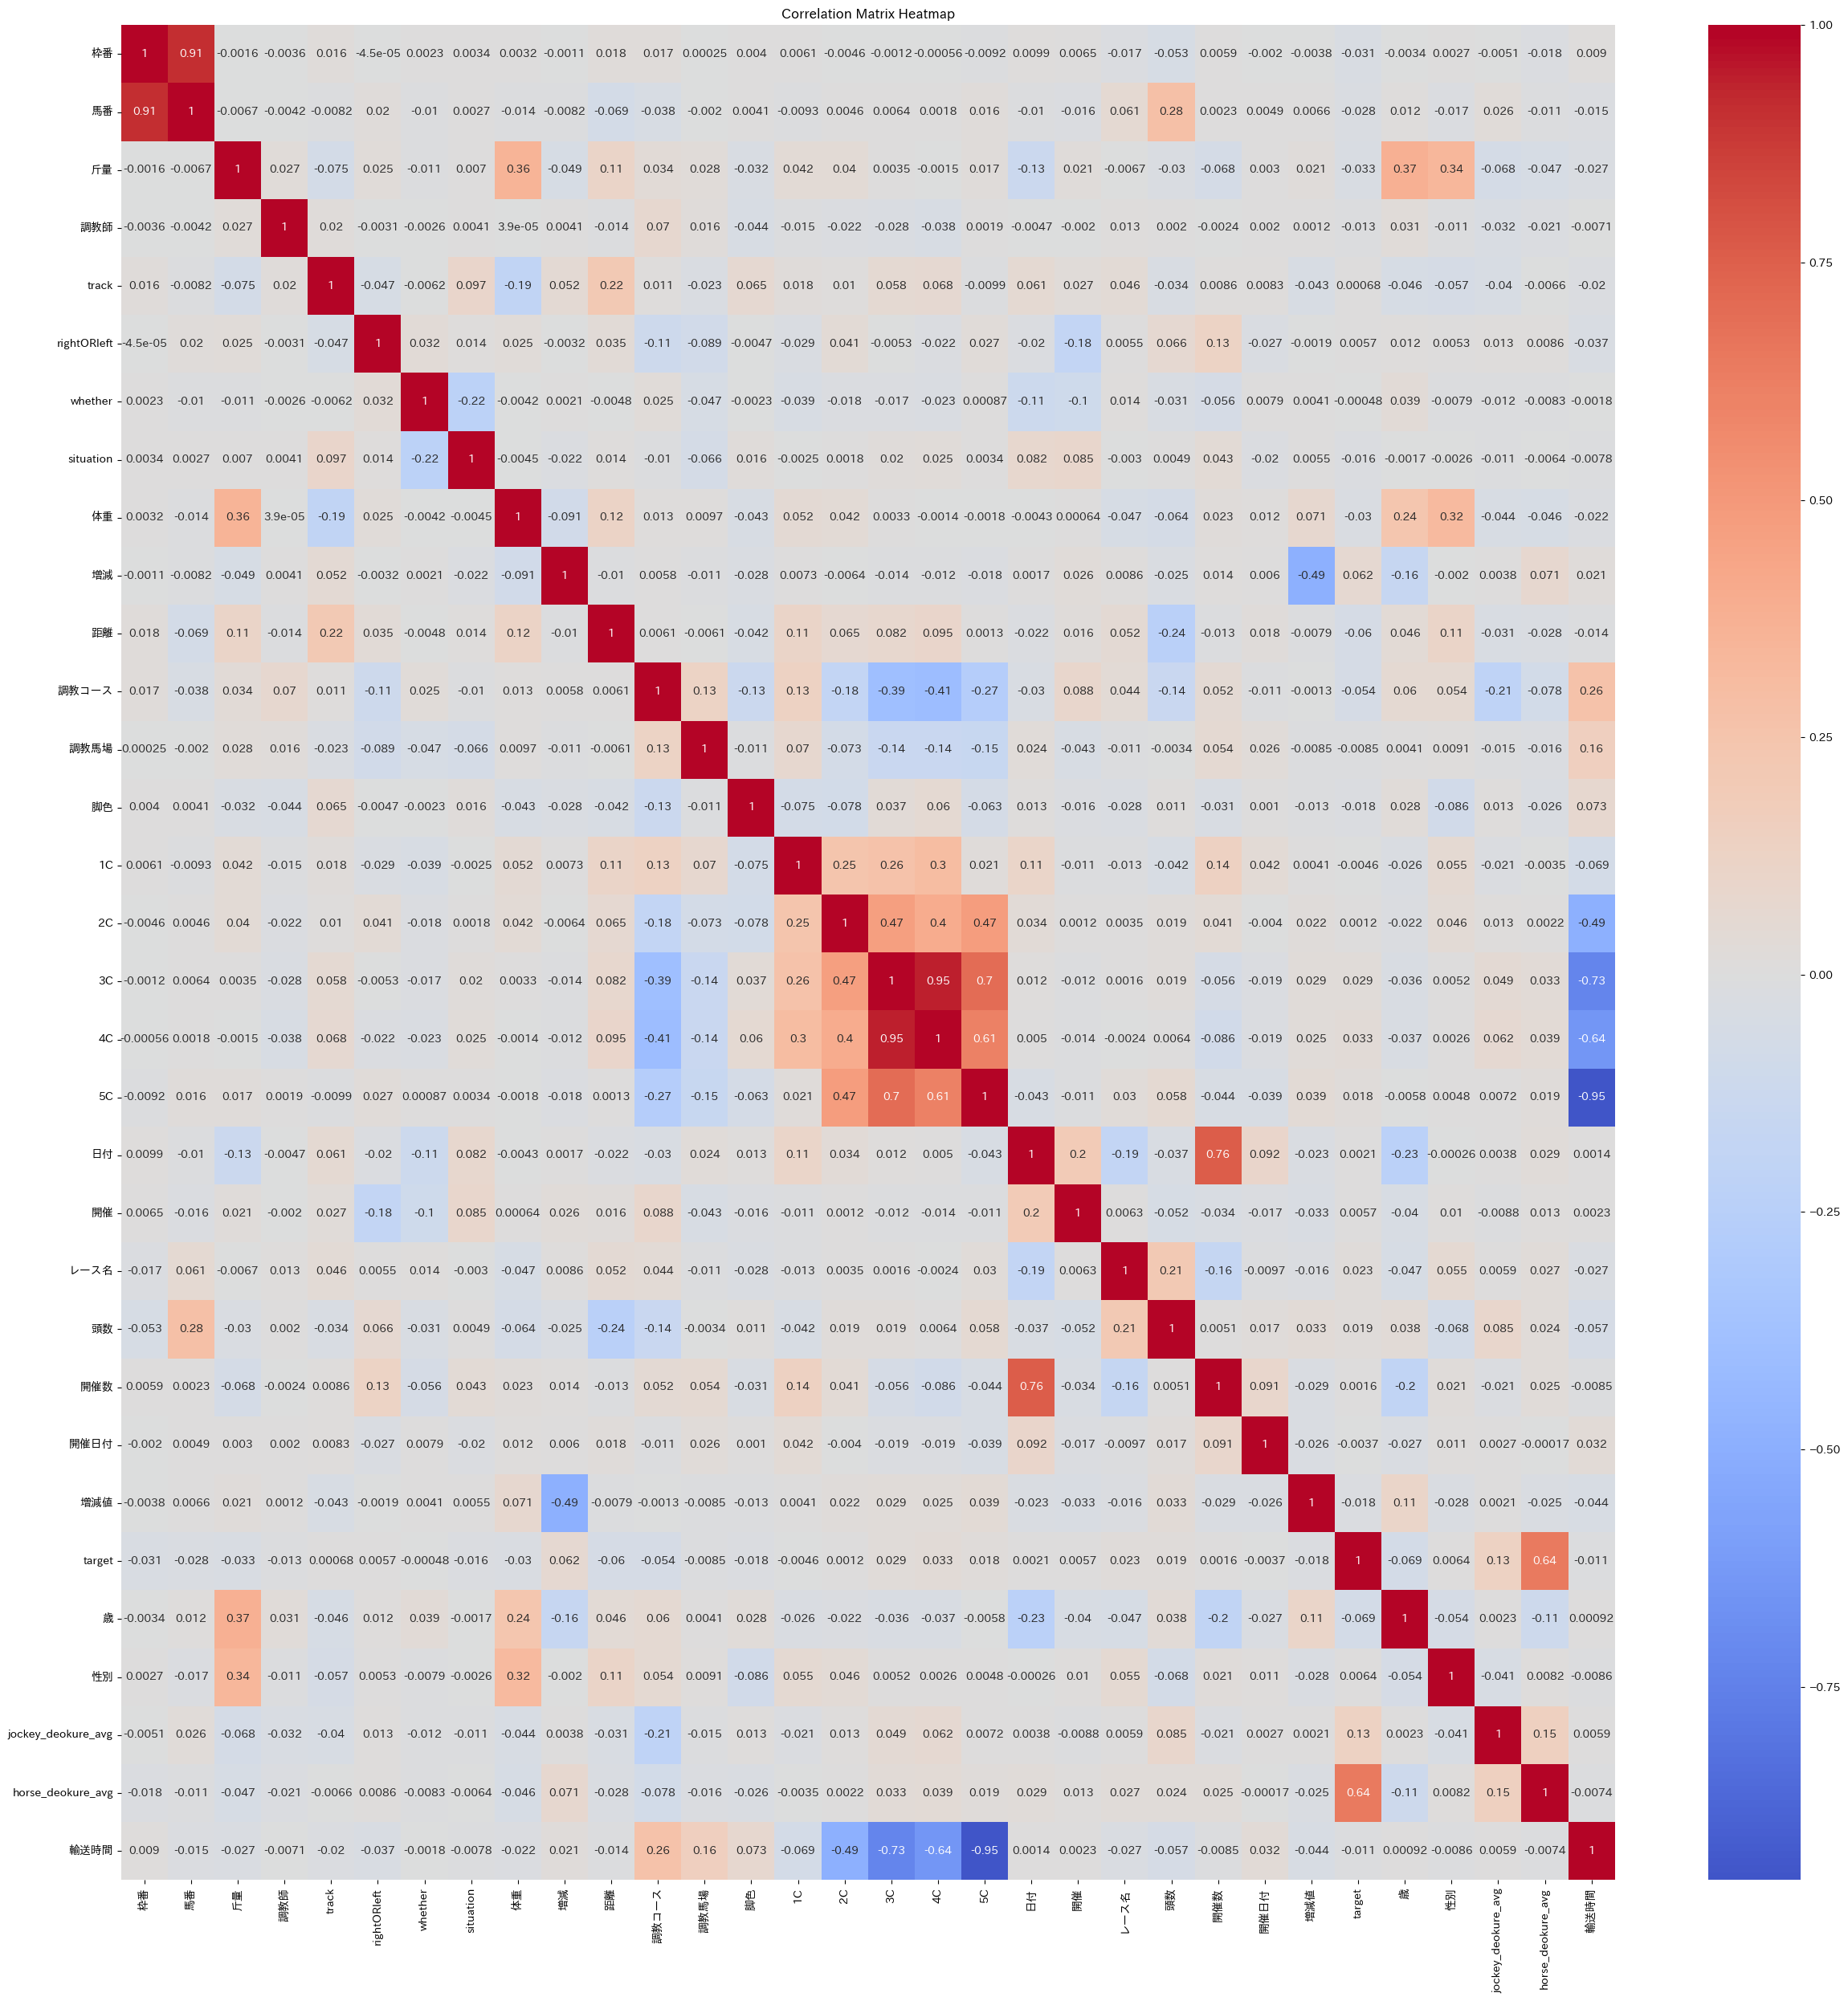

In [34]:
import japanize_matplotlib
# 相関行列の計算
corr_matrix = df.corr()

# 相関行列のヒートマップの描画
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [47]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Preparing the data
X = df.drop('target', axis=1).values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters
params = {
    'learning_rate': 0.010042693222915304,
    'max_depth': 5,
    'min_data_in_leaf': 35,
    'n_estimators': 32,
    'num_leaves': 27,
    'lambda_l1': 2.1405709345751944e-08,
    'lambda_l2': 4.221783897660626,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt'
}

# Creating and fitting the model
lgb_model = lgb.LGBMClassifier(**params)
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=2.1405709345751944e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1405709345751944e-08
[LightGBM] [Warning] lambda_l2 is set=4.221783897660626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.221783897660626
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=2.1405709345751944e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1405709345751944e-08
[LightGBM] [Warning] lambda_l2 is set=4.221783897660626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.221783897660626
[LightGBM] [Info] Number of positive: 9445, number of negative: 26934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003211 seconds.
You can set `force_col_wise=true` to

LGBMClassifier(lambda_l1=2.1405709345751944e-08, lambda_l2=4.221783897660626,
               learning_rate=0.010042693222915304, max_depth=5,
               metric='binary_logloss', min_data_in_leaf=35, n_estimators=32,
               num_leaves=27, objective='binary')

In [48]:
lgb_model.score(X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=2.1405709345751944e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1405709345751944e-08
[LightGBM] [Warning] lambda_l2 is set=4.221783897660626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.221783897660626


0.7329301814183617

In [37]:
df.drop('target', axis=1)

,枠番,馬番,斤量,調教師,track,rightORleft,whether,situation,体重,増減,距離,調教コース,調教馬場,脚色,1C,2C,3C,4C,5C,日付,開催,レース名,頭数,開催数,開催日付,増減値,歳,性別,jockey_deokure_avg,horse_deokure_avg,輸送時間
0,5,9,52.0,63,1,0,2,2,474,1,1200,1,2,6,0.0,71.1,55.7,41.6,13.4,1,6,6,16,1,1,22,3,1,0.256677,0.0,4
1,3,5,50.0,63,1,0,1,2,474,2,1200,1,2,2,0.0,71.8,55.6,40.7,12.9,2,3,0,16,1,2,0,3,1,0.256677,0.0,0
2,8,16,53.0,63,1,1,0,2,496,2,1200,4,4,8,0.0,52.6,38.6,25.4,12.8,1,5,6,16,1,1,0,3,1,0.315702,0.0,6
3,2,2,54.0,63,1,0,1,2,472,1,1400,4,2,6,0.0,53.7,39.2,25.1,12.3,3,9,1,15,6,8,6,3,1,0.315702,0.0,2
4,5,7,53.0,63,1,1,1,2,476,0,1400,4,2,0,0.0,53.7,39.3,25.6,12.8,3,7,1,13,4,1,2,3,1,0.247657,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45513,7,11,57.0,153,0,1,0,1,490,1,1900,5,3,5,0.0,0.0,0.0,0.0,0.0,1,0,0,14,3,6,6,5,0,0.090909,0.0,9999
45514,2,3,55.0,153,1,0,0,2,492,1,1800,4,2,6,0.0,52.3,38.2,25.2,13.0,0,4,0,16,1,2,14,5,1,0.090909,0.0,6
45515,8,9,56.0,128,1,0,1,3,498,0,2000,4,4,0,0.0,55.1,40.7,26.8,13.6,0,4,6,10,2,7,6,3,2,0.555556,0.0,6
45516,2,3,57.0,20,0,1,0,3,530,1,1800,0,2,6,85.6,69.7,55.1,40.0,12.0,2,5,1,15,4,2,2,6,2,0.000000,0.0,4


In [394]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)

In [49]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def objective(trial):
    # Splitting the data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    # Defining the parameters
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60),
        'n_estimators': trial.suggest_int('n_estimators', 30, 200),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'device': 'gpu'
    }
    verbose_eval = 0
    # Training the model
    lgb_model = lgb.LGBMClassifier(**param)
    lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

    # Custom cross-validation for early stopping
    val_pred = lgb_model.predict_proba(X_valid)[:, 1]
    return -log_loss(y_valid, val_pred)

# Creating and optimizing the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Training the best model
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X, y)
print('Best parameters:', study.best_params)
print('Feature importances:', best_model.feature_importances_)

[I 2023-11-23 20:36:26,982] A new study created in memory with name: no-name-37aa2557-15a6-4a3b-8e1b-d54ff2d6e04e


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=0.014637975637504512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014637975637504512
[LightGBM] [Warning] lambda_l2 is set=0.00030046197244603263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030046197244603263
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=0.014637975637504512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014637975637504512
[LightGBM] [Warning] lambda_l2 is set=0.00030046197244603263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030046197244603263
[LightGBM] [Info] Number of positive: 9473, number of negative: 26906
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the tra

[I 2023-11-23 20:36:28,099] Trial 0 finished with value: -0.3419345203775743 and parameters: {'learning_rate': 0.017161114939985782, 'max_depth': 17, 'min_data_in_leaf': 54, 'n_estimators': 137, 'num_leaves': 34, 'lambda_l1': 0.014637975637504512, 'lambda_l2': 0.00030046197244603263}. Best is trial 0 with value: -0.3419345203775743.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=0.014637975637504512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014637975637504512
[LightGBM] [Warning] lambda_l2 is set=0.00030046197244603263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030046197244603263
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=4.3981133147090475e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3981133147090475e-08
[LightGBM] [Warning] lambda_l2 is set=0.07755442171306698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07755442171306698
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=4.3981133147090475e-08, reg_alpha=0.0 wi

[I 2023-11-23 20:36:29,076] Trial 1 finished with value: -0.350546961918222 and parameters: {'learning_rate': 0.014935388313306267, 'max_depth': 12, 'min_data_in_leaf': 13, 'n_estimators': 150, 'num_leaves': 25, 'lambda_l1': 4.3981133147090475e-08, 'lambda_l2': 0.07755442171306698}. Best is trial 1 with value: -0.350546961918222.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=4.3981133147090475e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3981133147090475e-08
[LightGBM] [Warning] lambda_l2 is set=0.07755442171306698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07755442171306698
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=0.004227971305776691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004227971305776691
[LightGBM] [Warning] lambda_l2 is set=2.49177807849039e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.49177807849039e-06
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=0.004227971305776691, reg_alpha=0.0 will be 

[I 2023-11-23 20:36:29,972] Trial 2 finished with value: -0.3376075485521422 and parameters: {'learning_rate': 0.07836244134556714, 'max_depth': 13, 'min_data_in_leaf': 34, 'n_estimators': 151, 'num_leaves': 25, 'lambda_l1': 0.004227971305776691, 'lambda_l2': 2.49177807849039e-06}. Best is trial 1 with value: -0.350546961918222.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=0.004227971305776691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004227971305776691
[LightGBM] [Warning] lambda_l2 is set=2.49177807849039e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.49177807849039e-06
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.0688807879759342e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0688807879759342e-05
[LightGBM] [Warning] lambda_l2 is set=5.775255116116132e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.775255116116132e-06
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.0688807879759342e-05, reg_alpha=0.0 wi

[I 2023-11-23 20:36:30,641] Trial 3 finished with value: -0.3570025832092634 and parameters: {'learning_rate': 0.020198005785213642, 'max_depth': 10, 'min_data_in_leaf': 20, 'n_estimators': 87, 'num_leaves': 26, 'lambda_l1': 1.0688807879759342e-05, 'lambda_l2': 5.775255116116132e-06}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.0688807879759342e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0688807879759342e-05
[LightGBM] [Warning] lambda_l2 is set=5.775255116116132e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.775255116116132e-06
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] lambda_l1 is set=0.004289404471170388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004289404471170388
[LightGBM] [Warning] lambda_l2 is set=0.05879521294851543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05879521294851543
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] lambda_l1 is set=0.004289404471170388, reg_alpha=0.0 will b

[I 2023-11-23 20:36:30,991] Trial 4 finished with value: -0.3329063966401458 and parameters: {'learning_rate': 0.06024657402205797, 'max_depth': 4, 'min_data_in_leaf': 19, 'n_estimators': 58, 'num_leaves': 36, 'lambda_l1': 0.004289404471170388, 'lambda_l2': 0.05879521294851543}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] lambda_l1 is set=0.004289404471170388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004289404471170388
[LightGBM] [Warning] lambda_l2 is set=0.05879521294851543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05879521294851543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262734 -> initscore=-1.031807
[LightGBM] [Info] Start training from score -1.031807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2023-11-23 20:36:31,727] Trial 5 finished with value: -0.33142041749674783 and parameters: {'learning_rate': 0.027312020004199966, 'max_depth': 10, 'min_data_in_leaf': 23, 'n_estimators': 121, 'num_leaves': 22, 'lambda_l1': 8.917190596145202e-08, 'lambda_l2': 0.0014726722815075984}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=8.917190596145202e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.917190596145202e-08
[LightGBM] [Warning] lambda_l2 is set=0.0014726722815075984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014726722815075984
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=0.004515304305343221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004515304305343221
[LightGBM] [Warning] lambda_l2 is set=0.0010360096233709567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010360096233709567
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=0.004515304305343221, reg_alpha=0.0 will

[I 2023-11-23 20:36:32,208] Trial 6 finished with value: -0.3305049099593382 and parameters: {'learning_rate': 0.043869946928638645, 'max_depth': 3, 'min_data_in_leaf': 46, 'n_estimators': 176, 'num_leaves': 34, 'lambda_l1': 0.004515304305343221, 'lambda_l2': 0.0010360096233709567}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-23 20:36:32,975] Trial 7 finished with value: -0.3310390443857866 and parameters: {'learning_rate': 0.07834227134247725, 'max_depth': 9, 'min_data_in_leaf': 50, 'n_estimators': 116, 'num_leaves': 26, 'lambda_l1': 1.9019017475478718e-07, 'lambda_l2': 0.026317171698659342}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.9019017475478718e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9019017475478718e-07
[LightGBM] [Warning] lambda_l2 is set=0.026317171698659342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026317171698659342
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=0.05333993129935512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05333993129935512
[LightGBM] [Warning] lambda_l2 is set=1.9666717862676806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9666717862676806
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=0.05333993129935512, reg_alpha=0.0 will be ignor

[I 2023-11-23 20:36:33,417] Trial 8 finished with value: -0.3332351241396492 and parameters: {'learning_rate': 0.08720629211620047, 'max_depth': 23, 'min_data_in_leaf': 38, 'n_estimators': 37, 'num_leaves': 21, 'lambda_l1': 0.05333993129935512, 'lambda_l2': 1.9666717862676806}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=0.05333993129935512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05333993129935512
[LightGBM] [Warning] lambda_l2 is set=1.9666717862676806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9666717862676806
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=3.703248575795345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.703248575795345e-05
[LightGBM] [Warning] lambda_l2 is set=3.262755689748838e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.262755689748838e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be 

[I 2023-11-23 20:36:34,478] Trial 9 finished with value: -0.3298015627688296 and parameters: {'learning_rate': 0.0769415536824022, 'max_depth': 26, 'min_data_in_leaf': 42, 'n_estimators': 151, 'num_leaves': 31, 'lambda_l1': 3.703248575795345e-05, 'lambda_l2': 3.262755689748838e-06}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=3.703248575795345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.703248575795345e-05
[LightGBM] [Warning] lambda_l2 is set=3.262755689748838e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.262755689748838e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=7.3776966027826445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3776966027826445
[LightGBM] [Warning] lambda_l2 is set=2.454384852645058e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.454384852645058e-08
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will

[I 2023-11-23 20:36:35,314] Trial 10 finished with value: -0.33554862695563376 and parameters: {'learning_rate': 0.036200427911962346, 'max_depth': 18, 'min_data_in_leaf': 28, 'n_estimators': 78, 'num_leaves': 40, 'lambda_l1': 7.3776966027826445, 'lambda_l2': 2.454384852645058e-08}. Best is trial 3 with value: -0.3570025832092634.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=7.3776966027826445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3776966027826445
[LightGBM] [Warning] lambda_l2 is set=2.454384852645058e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.454384852645058e-08
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.0704435976326165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0704435976326165e-08
[LightGBM] [Warning] lambda_l2 is set=6.374367433549416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.374367433549416
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.0704435976326165e-08, reg_alpha=0.0 will be igno

[I 2023-11-23 20:36:36,059] Trial 11 finished with value: -0.39555788537073105 and parameters: {'learning_rate': 0.011172671616227155, 'max_depth': 12, 'min_data_in_leaf': 10, 'n_estimators': 87, 'num_leaves': 27, 'lambda_l1': 1.0704435976326165e-08, 'lambda_l2': 6.374367433549416}. Best is trial 11 with value: -0.39555788537073105.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.0704435976326165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0704435976326165e-08
[LightGBM] [Warning] lambda_l2 is set=6.374367433549416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.374367433549416
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=2.054625880082571e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.054625880082571e-06
[LightGBM] [Warning] lambda_l2 is set=8.393561920232685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.393561920232685
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=2.054625880082571e-06, reg_alpha=0.0 will be ignored

[I 2023-11-23 20:36:36,714] Trial 12 finished with value: -0.38340526479434295 and parameters: {'learning_rate': 0.014081833351829807, 'max_depth': 6, 'min_data_in_leaf': 10, 'n_estimators': 84, 'num_leaves': 29, 'lambda_l1': 2.054625880082571e-06, 'lambda_l2': 8.393561920232685}. Best is trial 11 with value: -0.39555788537073105.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2023-11-23 20:36:37,396] Trial 13 finished with value: -0.40032401080090063 and parameters: {'learning_rate': 0.011653794499882415, 'max_depth': 6, 'min_data_in_leaf': 10, 'n_estimators': 85, 'num_leaves': 29, 'lambda_l1': 1.0511968167038365e-08, 'lambda_l2': 6.356144781221443}. Best is trial 13 with value: -0.40032401080090063.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1.0511968167038365e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0511968167038365e-08
[LightGBM] [Warning] lambda_l2 is set=6.356144781221443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.356144781221443
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=2.026194447265178e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.026194447265178e-08
[LightGBM] [Warning] lambda_l2 is set=6.578625221433797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578625221433797
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=2.026194447265178e-08, reg_alpha=0.0 will be ignored

[I 2023-11-23 20:36:38,151] Trial 14 finished with value: -0.34139384186179594 and parameters: {'learning_rate': 0.03208043256111611, 'max_depth': 7, 'min_data_in_leaf': 60, 'n_estimators': 98, 'num_leaves': 30, 'lambda_l1': 2.026194447265178e-08, 'lambda_l2': 6.578625221433797}. Best is trial 13 with value: -0.40032401080090063.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=2.026194447265178e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.026194447265178e-08
[LightGBM] [Warning] lambda_l2 is set=6.578625221433797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578625221433797
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.4093407968945915e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4093407968945915e-08
[LightGBM] [Warning] lambda_l2 is set=0.4293026968839598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42

[I 2023-11-23 20:36:38,794] Trial 15 finished with value: -0.435350646485383 and parameters: {'learning_rate': 0.010176391887057925, 'max_depth': 15, 'min_data_in_leaf': 15, 'n_estimators': 61, 'num_leaves': 28, 'lambda_l1': 1.4093407968945915e-08, 'lambda_l2': 0.4293026968839598}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=1.4093407968945915e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4093407968945915e-08
[LightGBM] [Warning] lambda_l2 is set=0.4293026968839598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4293026968839598
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] lambda_l1 is set=5.209649429488832e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209649429488832e-07
[LightGBM] [Warning] lambda_l2 is set=0.2436518558387852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2436518558387852
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] lambda_l1 is set=5.209649429488832e-07, reg_alpha=0.0 will be ign

[I 2023-11-23 20:36:39,266] Trial 16 finished with value: -0.41728922181046 and parameters: {'learning_rate': 0.025026528989229323, 'max_depth': 21, 'min_data_in_leaf': 27, 'n_estimators': 30, 'num_leaves': 32, 'lambda_l1': 5.209649429488832e-07, 'lambda_l2': 0.2436518558387852}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] lambda_l1 is set=5.209649429488832e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209649429488832e-07
[LightGBM] [Warning] lambda_l2 is set=0.2436518558387852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2436518558387852
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=1.0190268614836643e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0190268614836643e-06
[LightGBM] [Warning] lambda_l2 is set=0.3182524060253532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3182524060253532
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=1.0190268614836643e-06, reg_alpha=0.0 will be ig

[I 2023-11-23 20:36:39,745] Trial 17 finished with value: -0.3738735941908131 and parameters: {'learning_rate': 0.04506420846443996, 'max_depth': 22, 'min_data_in_leaf': 29, 'n_estimators': 30, 'num_leaves': 33, 'lambda_l1': 1.0190268614836643e-06, 'lambda_l2': 0.3182524060253532}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=1.0190268614836643e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0190268614836643e-06
[LightGBM] [Warning] lambda_l2 is set=0.3182524060253532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3182524060253532
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=3.370330617521049e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.370330617521049e-07
[LightGBM] [Warning] lambda_l2 is set=0.562590127150856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.562590127150856
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=3.370330617521049e-07, reg_alpha=0.0 will be ignor

[I 2023-11-23 20:36:40,446] Trial 18 finished with value: -0.3740130840283922 and parameters: {'learning_rate': 0.026119534068415877, 'max_depth': 20, 'min_data_in_leaf': 26, 'n_estimators': 54, 'num_leaves': 38, 'lambda_l1': 3.370330617521049e-07, 'lambda_l2': 0.562590127150856}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=3.370330617521049e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.370330617521049e-07
[LightGBM] [Warning] lambda_l2 is set=0.562590127150856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.562590127150856
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=3.1600819318025076e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1600819318025076e-06
[LightGBM] [Warning] lambda_l2 is set=0.008242605908781604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008242605908781604
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=3.1600819318025076e-06, reg_alpha=0.0 will be 

[I 2023-11-23 20:36:41,036] Trial 19 finished with value: -0.3589294159310935 and parameters: {'learning_rate': 0.02948471874809829, 'max_depth': 29, 'min_data_in_leaf': 16, 'n_estimators': 56, 'num_leaves': 32, 'lambda_l1': 3.1600819318025076e-06, 'lambda_l2': 0.008242605908781604}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=3.1600819318025076e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1600819318025076e-06
[LightGBM] [Warning] lambda_l2 is set=0.008242605908781604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008242605908781604
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=7.610308727151304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610308727151304e-05
[LightGBM] [Warning] lambda_l2 is set=0.7701029019316339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7701029019316339
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=7.610308727151304e-05, reg_alpha=0.0 will be

[I 2023-11-23 20:36:41,612] Trial 20 finished with value: -0.3894849363911205 and parameters: {'learning_rate': 0.022508941119693447, 'max_depth': 15, 'min_data_in_leaf': 34, 'n_estimators': 43, 'num_leaves': 36, 'lambda_l1': 7.610308727151304e-05, 'lambda_l2': 0.7701029019316339}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=7.610308727151304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610308727151304e-05
[LightGBM] [Warning] lambda_l2 is set=0.7701029019316339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7701029019316339
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=1.0480113343066316e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0480113343066316e-08
[LightGBM] [Warning] lambda_l2 is set=0.248904454999963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.248904454999963
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=1.0480113343066316e-08, reg_alpha=0.0 will be igno

[I 2023-11-23 20:36:42,259] Trial 21 finished with value: -0.4084889215113613 and parameters: {'learning_rate': 0.01164931918678062, 'max_depth': 23, 'min_data_in_leaf': 16, 'n_estimators': 70, 'num_leaves': 28, 'lambda_l1': 1.0480113343066316e-08, 'lambda_l2': 0.248904454999963}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l1 is set=1.0480113343066316e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0480113343066316e-08
[LightGBM] [Warning] lambda_l2 is set=0.248904454999963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.248904454999963
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.7533015234083334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7533015234083334e-07
[LightGBM] [Warning] lambda_l2 is set=0.21012684740801651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21012684740801651
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.7533015234083334e-07, reg_alpha=0.0 will be 

[I 2023-11-23 20:36:42,894] Trial 22 finished with value: -0.4206345019989618 and parameters: {'learning_rate': 0.010269931233484459, 'max_depth': 23, 'min_data_in_leaf': 17, 'n_estimators': 67, 'num_leaves': 28, 'lambda_l1': 1.7533015234083334e-07, 'lambda_l2': 0.21012684740801651}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.7533015234083334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7533015234083334e-07
[LightGBM] [Warning] lambda_l2 is set=0.21012684740801651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21012684740801651
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=1.9497316506208325e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9497316506208325e-07
[LightGBM] [Warning] lambda_l2 is set=0.1614126752546125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1614126752546125
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=1.9497316506208325e-07, reg_alpha=0.0 will b

[I 2023-11-23 20:36:43,472] Trial 23 finished with value: -0.3646155655027202 and parameters: {'learning_rate': 0.02523800216585815, 'max_depth': 26, 'min_data_in_leaf': 23, 'n_estimators': 63, 'num_leaves': 24, 'lambda_l1': 1.9497316506208325e-07, 'lambda_l2': 0.1614126752546125}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=1.9497316506208325e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9497316506208325e-07
[LightGBM] [Warning] lambda_l2 is set=0.1614126752546125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1614126752546125
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=5.648366344815876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.648366344815876e-07
[LightGBM] [Warning] lambda_l2 is set=0.013182329355510763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013182329355510763
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=5.648366344815876e-07, reg_alpha=0.0 will be

[I 2023-11-23 20:36:44,004] Trial 24 finished with value: -0.3975421737744907 and parameters: {'learning_rate': 0.020159555147815353, 'max_depth': 20, 'min_data_in_leaf': 18, 'n_estimators': 45, 'num_leaves': 32, 'lambda_l1': 5.648366344815876e-07, 'lambda_l2': 0.013182329355510763}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=5.648366344815876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.648366344815876e-07
[LightGBM] [Warning] lambda_l2 is set=0.013182329355510763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013182329355510763
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=6.619090077676788e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.619090077676788e-08
[LightGBM] [Warning] lambda_l2 is set=0.9442418594267736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9442418594267736
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=6.619090077676788e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:36:44,408] Trial 25 finished with value: -0.4341958172156083 and parameters: {'learning_rate': 0.019607756235812204, 'max_depth': 15, 'min_data_in_leaf': 23, 'n_estimators': 30, 'num_leaves': 23, 'lambda_l1': 6.619090077676788e-08, 'lambda_l2': 0.9442418594267736}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=6.21622660255426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.21622660255426e-08
[LightGBM] [Warning] lambda_l2 is set=1.2867269929591596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2867269929591596
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=6.21622660255426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.21622660255426e-08
[LightGBM] [Warning] lambda_l2 is set=1.2867269929591596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2867269929591596
[LightGBM] [Info] Number of positive: 9524, number of negative: 26855
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 36379, n

[I 2023-11-23 20:36:45,021] Trial 26 finished with value: -0.3705864323520945 and parameters: {'learning_rate': 0.0199514920164059, 'max_depth': 16, 'min_data_in_leaf': 22, 'n_estimators': 69, 'num_leaves': 23, 'lambda_l1': 6.21622660255426e-08, 'lambda_l2': 1.2867269929591596}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=6.21622660255426e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.21622660255426e-08
[LightGBM] [Warning] lambda_l2 is set=1.2867269929591596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2867269929591596
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=5.4493911163316707e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4493911163316707e-08
[LightGBM] [Warning] lambda_l2 is set=1.4057923989955776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4057923989955776
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=5.4493911163316707e-08, reg_alpha=0.0 will be igno

[I 2023-11-23 20:36:45,694] Trial 27 finished with value: -0.33078062739099084 and parameters: {'learning_rate': 0.036815571180183776, 'max_depth': 15, 'min_data_in_leaf': 15, 'n_estimators': 104, 'num_leaves': 20, 'lambda_l1': 5.4493911163316707e-08, 'lambda_l2': 1.4057923989955776}. Best is trial 15 with value: -0.435350646485383.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=5.4493911163316707e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4493911163316707e-08
[LightGBM] [Warning] lambda_l2 is set=1.4057923989955776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4057923989955776
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=4.128359788776846e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.128359788776846e-06
[LightGBM] [Warning] lambda_l2 is set=0.03266014223831249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03266014223831249
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=4.128359788776846e-06, reg_alpha=0.0 will be i

[I 2023-11-23 20:36:46,210] Trial 28 finished with value: -0.455326265715154 and parameters: {'learning_rate': 0.010011276546639662, 'max_depth': 18, 'min_data_in_leaf': 31, 'n_estimators': 48, 'num_leaves': 28, 'lambda_l1': 4.128359788776846e-06, 'lambda_l2': 0.03266014223831249}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=4.128359788776846e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.128359788776846e-06
[LightGBM] [Warning] lambda_l2 is set=0.03266014223831249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03266014223831249
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=4.789312844402556e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.789312844402556e-06
[LightGBM] [Warning] lambda_l2 is set=0.04922978039727009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04922978039727009
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=4.789312844402556e-06, reg_alpha=0.0 will be i

[I 2023-11-23 20:36:47,330] Trial 29 finished with value: -0.3400578469933003 and parameters: {'learning_rate': 0.01396450449714784, 'max_depth': 18, 'min_data_in_leaf': 37, 'n_estimators': 200, 'num_leaves': 22, 'lambda_l1': 4.789312844402556e-06, 'lambda_l2': 0.04922978039727009}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=4.789312844402556e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.789312844402556e-06
[LightGBM] [Warning] lambda_l2 is set=0.04922978039727009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04922978039727009
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=9.472568146768663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.472568146768663e-07
[LightGBM] [Warning] lambda_l2 is set=0.005667286933984677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005667286933984677
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=9.472568146768663e-07, reg_alpha=0.0 will be

[I 2023-11-23 20:36:47,829] Trial 30 finished with value: -0.3968498397479641 and parameters: {'learning_rate': 0.0199078109424285, 'max_depth': 14, 'min_data_in_leaf': 31, 'n_estimators': 45, 'num_leaves': 24, 'lambda_l1': 9.472568146768663e-07, 'lambda_l2': 0.005667286933984677}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=9.472568146768663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.472568146768663e-07
[LightGBM] [Warning] lambda_l2 is set=0.005667286933984677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005667286933984677
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=1.26676231294509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.26676231294509e-07
[LightGBM] [Warning] lambda_l2 is set=0.10404222598401588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10404222598401588
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=1.26676231294509e-07, reg_alpha=0.0 will be ig

[I 2023-11-23 20:36:48,417] Trial 31 finished with value: -0.43850675788215343 and parameters: {'learning_rate': 0.011037697607525715, 'max_depth': 18, 'min_data_in_leaf': 24, 'n_estimators': 51, 'num_leaves': 28, 'lambda_l1': 1.26676231294509e-07, 'lambda_l2': 0.10404222598401588}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=1.26676231294509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.26676231294509e-07
[LightGBM] [Warning] lambda_l2 is set=0.10404222598401588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10404222598401588
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] lambda_l1 is set=5.323931543804743e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.323931543804743e-08
[LightGBM] [Warning] lambda_l2 is set=0.06567854480413834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06567854480413834
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] lambda_l1 is set=5.323931543804743e-08, reg_alpha=0.0 will be ign

[I 2023-11-23 20:36:48,946] Trial 32 finished with value: -0.40947916893362374 and parameters: {'learning_rate': 0.017184365336672548, 'max_depth': 17, 'min_data_in_leaf': 32, 'n_estimators': 50, 'num_leaves': 27, 'lambda_l1': 5.323931543804743e-08, 'lambda_l2': 0.06567854480413834}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] lambda_l1 is set=5.323931543804743e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.323931543804743e-08
[LightGBM] [Warning] lambda_l2 is set=0.06567854480413834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06567854480413834
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=4.015721294776597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.015721294776597e-08
[LightGBM] [Warning] lambda_l2 is set=0.016253722363600998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016253722363600998
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=4.015721294776597e-08, reg_alpha=0.0 will be

[I 2023-11-23 20:36:49,410] Trial 33 finished with value: -0.43773518079697493 and parameters: {'learning_rate': 0.01632193829999404, 'max_depth': 19, 'min_data_in_leaf': 25, 'n_estimators': 34, 'num_leaves': 30, 'lambda_l1': 4.015721294776597e-08, 'lambda_l2': 0.016253722363600998}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=4.015721294776597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.015721294776597e-08
[LightGBM] [Warning] lambda_l2 is set=0.016253722363600998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016253722363600998
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=3.542495550097928e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.542495550097928e-08
[LightGBM] [Warning] lambda_l2 is set=0.022488801181354635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022488801181354635
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=3.542495550097928e-08, reg_alpha=0.0 will 

[I 2023-11-23 20:36:49,974] Trial 34 finished with value: -0.4278664870517704 and parameters: {'learning_rate': 0.016076983964567654, 'max_depth': 19, 'min_data_in_leaf': 25, 'n_estimators': 41, 'num_leaves': 30, 'lambda_l1': 3.542495550097928e-08, 'lambda_l2': 0.022488801181354635}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=3.542495550097928e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.542495550097928e-08
[LightGBM] [Warning] lambda_l2 is set=0.022488801181354635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022488801181354635
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.03930729053133e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.03930729053133e-05
[LightGBM] [Warning] lambda_l2 is set=0.0036017111844322794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036017111844322794
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.03930729053133e-05, reg_alpha=0.0 will b

[I 2023-11-23 20:36:50,696] Trial 35 finished with value: -0.41156416581119015 and parameters: {'learning_rate': 0.010625507170606015, 'max_depth': 17, 'min_data_in_leaf': 20, 'n_estimators': 76, 'num_leaves': 26, 'lambda_l1': 1.03930729053133e-05, 'lambda_l2': 0.0036017111844322794}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=1.03930729053133e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.03930729053133e-05
[LightGBM] [Warning] lambda_l2 is set=0.0036017111844322794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036017111844322794
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.3829313916158883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3829313916158883e-07
[LightGBM] [Warning] lambda_l2 is set=0.0822451756004845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0822451756004845
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.3829313916158883e-07, reg_alpha=0.0 will b

[I 2023-11-23 20:36:51,374] Trial 36 finished with value: -0.388185065224823 and parameters: {'learning_rate': 0.016851662503419258, 'max_depth': 12, 'min_data_in_leaf': 30, 'n_estimators': 60, 'num_leaves': 29, 'lambda_l1': 1.3829313916158883e-07, 'lambda_l2': 0.0822451756004845}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.3829313916158883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3829313916158883e-07
[LightGBM] [Warning] lambda_l2 is set=0.0822451756004845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0822451756004845
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=2.7181147938734757e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7181147938734757e-08
[LightGBM] [Warning] lambda_l2 is set=0.019111873780964298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019111873780964298
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=2.7181147938734757e-08, reg_alpha=0.0 will

[I 2023-11-23 20:36:52,452] Trial 37 finished with value: -0.33840019432028556 and parameters: {'learning_rate': 0.02262180020444563, 'max_depth': 25, 'min_data_in_leaf': 39, 'n_estimators': 133, 'num_leaves': 28, 'lambda_l1': 2.7181147938734757e-08, 'lambda_l2': 0.019111873780964298}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=2.7181147938734757e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7181147938734757e-08
[LightGBM] [Warning] lambda_l2 is set=0.019111873780964298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019111873780964298
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=1.4928826774372044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4928826774372044e-06
[LightGBM] [Warning] lambda_l2 is set=0.0003357523732655737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003357523732655737
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=1.4928826774372044e-06, reg_alpha=0.

[I 2023-11-23 20:36:53,499] Trial 38 finished with value: -0.3662907743983436 and parameters: {'learning_rate': 0.0156646195696238, 'max_depth': 13, 'min_data_in_leaf': 13, 'n_estimators': 97, 'num_leaves': 34, 'lambda_l1': 1.4928826774372044e-06, 'lambda_l2': 0.0003357523732655737}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=1.4928826774372044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4928826774372044e-06
[LightGBM] [Warning] lambda_l2 is set=0.0003357523732655737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003357523732655737
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] lambda_l1 is set=3.3421571123999164e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3421571123999164e-07
[LightGBM] [Warning] lambda_l2 is set=0.003105045385343499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003105045385343499
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples

[I 2023-11-23 20:36:54,156] Trial 39 finished with value: -0.36444450977268833 and parameters: {'learning_rate': 0.029932308732365055, 'max_depth': 19, 'min_data_in_leaf': 21, 'n_estimators': 53, 'num_leaves': 31, 'lambda_l1': 3.3421571123999164e-07, 'lambda_l2': 0.003105045385343499}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] lambda_l1 is set=3.3421571123999164e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3421571123999164e-07
[LightGBM] [Warning] lambda_l2 is set=0.003105045385343499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003105045385343499
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=1.1700240199836408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1700240199836408e-07
[LightGBM] [Warning] lambda_l2 is set=0.041298265652419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.041298265652419
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will

[I 2023-11-23 20:36:55,390] Trial 40 finished with value: -0.3451014040738858 and parameters: {'learning_rate': 0.016249894055369928, 'max_depth': 9, 'min_data_in_leaf': 25, 'n_estimators': 166, 'num_leaves': 25, 'lambda_l1': 1.1700240199836408e-07, 'lambda_l2': 0.041298265652419}. Best is trial 28 with value: -0.455326265715154.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=1.1700240199836408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1700240199836408e-07
[LightGBM] [Warning] lambda_l2 is set=0.041298265652419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.041298265652419
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=3.6976534644657617e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6976534644657617e-08
[LightGBM] [Warning] lambda_l2 is set=0.09458910236064713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09458910236064713
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=3.6976534644657617e-08, reg_alpha=0.0 will be 

[I 2023-11-23 20:36:55,890] Trial 41 finished with value: -0.46956440068876243 and parameters: {'learning_rate': 0.010003508955179099, 'max_depth': 16, 'min_data_in_leaf': 24, 'n_estimators': 36, 'num_leaves': 27, 'lambda_l1': 3.6976534644657617e-08, 'lambda_l2': 0.09458910236064713}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=3.6976534644657617e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6976534644657617e-08
[LightGBM] [Warning] lambda_l2 is set=0.09458910236064713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09458910236064713
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.333011611985296e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333011611985296e-08
[LightGBM] [Warning] lambda_l2 is set=0.1014034196885285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1014034196885285
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.333011611985296e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:36:56,470] Trial 42 finished with value: -0.4694818881471646 and parameters: {'learning_rate': 0.010035055641923842, 'max_depth': 16, 'min_data_in_leaf': 33, 'n_estimators': 38, 'num_leaves': 27, 'lambda_l1': 3.333011611985296e-08, 'lambda_l2': 0.1014034196885285}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.333011611985296e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333011611985296e-08
[LightGBM] [Warning] lambda_l2 is set=0.1014034196885285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1014034196885285
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=3.6995439306487335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6995439306487335e-07
[LightGBM] [Warning] lambda_l2 is set=0.10359652865431243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10359652865431243
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=3.6995439306487335e-07, reg_alpha=0.0 will be 

[I 2023-11-23 20:36:57,053] Trial 43 finished with value: -0.40256191717440665 and parameters: {'learning_rate': 0.02276495019788934, 'max_depth': 18, 'min_data_in_leaf': 34, 'n_estimators': 40, 'num_leaves': 27, 'lambda_l1': 3.6995439306487335e-07, 'lambda_l2': 0.10359652865431243}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=3.6995439306487335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6995439306487335e-07
[LightGBM] [Warning] lambda_l2 is set=0.10359652865431243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10359652865431243
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=5.2439037987300616e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2439037987300616e-08
[LightGBM] [Warning] lambda_l2 is set=0.012443931120275392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012443931120275392
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=5.2439037987300616e-08, reg_alpha=0.0 wi

[I 2023-11-23 20:36:57,538] Trial 44 finished with value: -0.4456786942634428 and parameters: {'learning_rate': 0.014991190738152195, 'max_depth': 16, 'min_data_in_leaf': 43, 'n_estimators': 36, 'num_leaves': 26, 'lambda_l1': 5.2439037987300616e-08, 'lambda_l2': 0.012443931120275392}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=5.2439037987300616e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2439037987300616e-08
[LightGBM] [Warning] lambda_l2 is set=0.012443931120275392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012443931120275392
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.2642010075909227e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2642010075909227e-07
[LightGBM] [Warning] lambda_l2 is set=0.0016673150752399097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016673150752399097
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.2642010075909227e-07, reg_alpha=0.

[I 2023-11-23 20:36:58,089] Trial 45 finished with value: -0.4502024510322479 and parameters: {'learning_rate': 0.010011855602546482, 'max_depth': 13, 'min_data_in_leaf': 44, 'n_estimators': 49, 'num_leaves': 25, 'lambda_l1': 1.2642010075909227e-07, 'lambda_l2': 0.0016673150752399097}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.2642010075909227e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2642010075909227e-07
[LightGBM] [Warning] lambda_l2 is set=0.0016673150752399097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016673150752399097
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=3.054182251529337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054182251529337e-08
[LightGBM] [Warning] lambda_l2 is set=0.0012424974568088435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012424974568088435
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=3.054182251529337e-08, reg_alpha=0.0

[I 2023-11-23 20:36:58,572] Trial 46 finished with value: -0.4413465276820969 and parameters: {'learning_rate': 0.014366734349927638, 'max_depth': 11, 'min_data_in_leaf': 45, 'n_estimators': 38, 'num_leaves': 26, 'lambda_l1': 3.054182251529337e-08, 'lambda_l2': 0.0012424974568088435}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=3.054182251529337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054182251529337e-08
[LightGBM] [Warning] lambda_l2 is set=0.0012424974568088435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012424974568088435
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=8.034587502637056e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.034587502637056e-07
[LightGBM] [Warning] lambda_l2 is set=0.0005098171326407015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005098171326407015
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=8.034587502637056e-07, reg_alpha=0.0 w

[I 2023-11-23 20:36:59,147] Trial 47 finished with value: -0.40845351576268923 and parameters: {'learning_rate': 0.018708178900056324, 'max_depth': 13, 'min_data_in_leaf': 52, 'n_estimators': 49, 'num_leaves': 25, 'lambda_l1': 8.034587502637056e-07, 'lambda_l2': 0.0005098171326407015}. Best is trial 41 with value: -0.46956440068876243.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=8.034587502637056e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.034587502637056e-07
[LightGBM] [Warning] lambda_l2 is set=0.0005098171326407015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005098171326407015
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.9610668770404676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9610668770404676e-06
[LightGBM] [Warning] lambda_l2 is set=7.434565649751153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.434565649751153e-05
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.9610668770404676e-06, reg_alpha=0.

[I 2023-11-23 20:36:59,691] Trial 48 finished with value: -0.47829566761497283 and parameters: {'learning_rate': 0.010097612995064474, 'max_depth': 16, 'min_data_in_leaf': 42, 'n_estimators': 36, 'num_leaves': 24, 'lambda_l1': 1.9610668770404676e-06, 'lambda_l2': 7.434565649751153e-05}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.9610668770404676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9610668770404676e-06
[LightGBM] [Warning] lambda_l2 is set=7.434565649751153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.434565649751153e-05
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=4.71173939667813e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71173939667813e-06
[LightGBM] [Warning] lambda_l2 is set=7.973033158167862e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.973033158167862e-05
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=4.71173939667813e-06, reg_alpha=0.0 wi

[I 2023-11-23 20:37:00,341] Trial 49 finished with value: -0.3577624612150197 and parameters: {'learning_rate': 0.02392619643852295, 'max_depth': 14, 'min_data_in_leaf': 40, 'n_estimators': 75, 'num_leaves': 23, 'lambda_l1': 4.71173939667813e-06, 'lambda_l2': 7.973033158167862e-05}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=4.71173939667813e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71173939667813e-06
[LightGBM] [Warning] lambda_l2 is set=7.973033158167862e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.973033158167862e-05
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.2798163390454204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2798163390454204e-05
[LightGBM] [Warning] lambda_l2 is set=8.417499685835958e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.417499685835958e-05
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.2798163390454204e-05, reg_alpha=0.0 

[I 2023-11-23 20:37:00,926] Trial 50 finished with value: -0.37712278847032243 and parameters: {'learning_rate': 0.027429205591171547, 'max_depth': 10, 'min_data_in_leaf': 46, 'n_estimators': 46, 'num_leaves': 24, 'lambda_l1': 1.2798163390454204e-05, 'lambda_l2': 8.417499685835958e-05}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.2798163390454204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2798163390454204e-05
[LightGBM] [Warning] lambda_l2 is set=8.417499685835958e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.417499685835958e-05
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.7817530785493003e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7817530785493003e-06
[LightGBM] [Warning] lambda_l2 is set=0.0030966969427909433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030966969427909433
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.7817530785493003e-06, reg_alpha=

[I 2023-11-23 20:37:01,455] Trial 51 finished with value: -0.4507319513713875 and parameters: {'learning_rate': 0.014008878939016114, 'max_depth': 16, 'min_data_in_leaf': 43, 'n_estimators': 34, 'num_leaves': 26, 'lambda_l1': 1.7817530785493003e-06, 'lambda_l2': 0.0030966969427909433}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.7817530785493003e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7817530785493003e-06
[LightGBM] [Warning] lambda_l2 is set=0.0030966969427909433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030966969427909433
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.7018945173943668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7018945173943668e-06
[LightGBM] [Warning] lambda_l2 is set=0.003725742829457382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003725742829457382
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.7018945173943668e-06, reg_alpha=0.

[I 2023-11-23 20:37:01,962] Trial 52 finished with value: -0.46515813542381657 and parameters: {'learning_rate': 0.010057205063123653, 'max_depth': 16, 'min_data_in_leaf': 48, 'n_estimators': 40, 'num_leaves': 25, 'lambda_l1': 1.7018945173943668e-06, 'lambda_l2': 0.003725742829457382}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.7018945173943668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7018945173943668e-06
[LightGBM] [Warning] lambda_l2 is set=0.003725742829457382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003725742829457382
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=2.2081541797951554e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2081541797951554e-06
[LightGBM] [Warning] lambda_l2 is set=0.03316767620221708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03316767620221708
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=2.2081541797951554e-06, reg_alpha=0.0 wi

[I 2023-11-23 20:37:02,482] Trial 53 finished with value: -0.44252201345057446 and parameters: {'learning_rate': 0.013939275783659048, 'max_depth': 16, 'min_data_in_leaf': 49, 'n_estimators': 36, 'num_leaves': 26, 'lambda_l1': 2.2081541797951554e-06, 'lambda_l2': 0.03316767620221708}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=2.2081541797951554e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2081541797951554e-06
[LightGBM] [Warning] lambda_l2 is set=0.03316767620221708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03316767620221708
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.1252456969130983e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1252456969130983e-06
[LightGBM] [Warning] lambda_l2 is set=0.0038864622851644635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038864622851644635
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.1252456969130983e-06, reg_alpha=0.0 

[I 2023-11-23 20:37:02,955] Trial 54 finished with value: -0.46335527882788213 and parameters: {'learning_rate': 0.01332543489637, 'max_depth': 21, 'min_data_in_leaf': 48, 'n_estimators': 30, 'num_leaves': 27, 'lambda_l1': 1.1252456969130983e-06, 'lambda_l2': 0.0038864622851644635}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=1.1252456969130983e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1252456969130983e-06
[LightGBM] [Warning] lambda_l2 is set=0.0038864622851644635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038864622851644635
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=4.3784489154310576e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3784489154310576e-05
[LightGBM] [Warning] lambda_l2 is set=0.00708858987821945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00708858987821945
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=4.3784489154310576e-05, reg_alpha=0.0 

[I 2023-11-23 20:37:03,487] Trial 55 finished with value: -0.44667234732393835 and parameters: {'learning_rate': 0.01874342286558036, 'max_depth': 21, 'min_data_in_leaf': 56, 'n_estimators': 30, 'num_leaves': 27, 'lambda_l1': 4.3784489154310576e-05, 'lambda_l2': 0.00708858987821945}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=4.3784489154310576e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3784489154310576e-05
[LightGBM] [Warning] lambda_l2 is set=0.00708858987821945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00708858987821945
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=7.265409523337324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.265409523337324e-07
[LightGBM] [Warning] lambda_l2 is set=0.026237557792582588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026237557792582588
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=7.265409523337324e-07, reg_alpha=0.0 will 

[I 2023-11-23 20:37:04,260] Trial 56 finished with value: -0.3734016282328933 and parameters: {'learning_rate': 0.02194406004786288, 'max_depth': 21, 'min_data_in_leaf': 49, 'n_estimators': 60, 'num_leaves': 29, 'lambda_l1': 7.265409523337324e-07, 'lambda_l2': 0.026237557792582588}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=7.265409523337324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.265409523337324e-07
[LightGBM] [Warning] lambda_l2 is set=0.026237557792582588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026237557792582588
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=2.8020871198998196e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8020871198998196e-07
[LightGBM] [Warning] lambda_l2 is set=0.007308018942160448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007308018942160448
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=2.8020871198998196e-07, reg_alpha=0.0 wi

[I 2023-11-23 20:37:04,866] Trial 57 finished with value: -0.44531568713294867 and parameters: {'learning_rate': 0.012811259737228423, 'max_depth': 17, 'min_data_in_leaf': 36, 'n_estimators': 40, 'num_leaves': 22, 'lambda_l1': 2.8020871198998196e-07, 'lambda_l2': 0.007308018942160448}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=2.8020871198998196e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8020871198998196e-07
[LightGBM] [Warning] lambda_l2 is set=0.007308018942160448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007308018942160448
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=0.00016884944227735487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016884944227735487
[LightGBM] [Warning] lambda_l2 is set=0.0006805800264627547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006805800264627547
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=0.00016884944227735487, reg_alpha=0.

[I 2023-11-23 20:37:05,553] Trial 58 finished with value: -0.4226915894566529 and parameters: {'learning_rate': 0.01251790282821803, 'max_depth': 20, 'min_data_in_leaf': 56, 'n_estimators': 56, 'num_leaves': 24, 'lambda_l1': 0.00016884944227735487, 'lambda_l2': 0.0006805800264627547}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] lambda_l1 is set=0.00016884944227735487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016884944227735487
[LightGBM] [Warning] lambda_l2 is set=0.0006805800264627547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006805800264627547
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.149267227168678e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.149267227168678e-05
[LightGBM] [Warning] lambda_l2 is set=0.048412250795086105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.048412250795086105
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.149267227168678e-05, reg_alpha=0.0 w

[I 2023-11-23 20:37:06,186] Trial 59 finished with value: -0.41255408423163803 and parameters: {'learning_rate': 0.01826418999720256, 'max_depth': 22, 'min_data_in_leaf': 47, 'n_estimators': 43, 'num_leaves': 27, 'lambda_l1': 1.149267227168678e-05, 'lambda_l2': 0.048412250795086105}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.149267227168678e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.149267227168678e-05
[LightGBM] [Warning] lambda_l2 is set=0.048412250795086105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.048412250795086105
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=1.860208058368067e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.860208058368067e-08
[LightGBM] [Warning] lambda_l2 is set=0.3025735358554074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3025735358554074
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=1.860208058368067e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:37:07,335] Trial 60 finished with value: -0.3712786219734199 and parameters: {'learning_rate': 0.010580097688485916, 'max_depth': 25, 'min_data_in_leaf': 52, 'n_estimators': 125, 'num_leaves': 29, 'lambda_l1': 1.860208058368067e-08, 'lambda_l2': 0.3025735358554074}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] lambda_l1 is set=1.860208058368067e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.860208058368067e-08
[LightGBM] [Warning] lambda_l2 is set=0.3025735358554074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3025735358554074
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=1.7448420519025746e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7448420519025746e-06
[LightGBM] [Warning] lambda_l2 is set=0.0015597360827077464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015597360827077464
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=1.7448420519025746e-06, reg_alpha=0.0 will

[I 2023-11-23 20:37:07,877] Trial 61 finished with value: -0.45354149066265825 and parameters: {'learning_rate': 0.014009080442036557, 'max_depth': 14, 'min_data_in_leaf': 41, 'n_estimators': 34, 'num_leaves': 26, 'lambda_l1': 1.7448420519025746e-06, 'lambda_l2': 0.0015597360827077464}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=1.7448420519025746e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7448420519025746e-06
[LightGBM] [Warning] lambda_l2 is set=0.0015597360827077464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015597360827077464
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=5.25766195621719e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.25766195621719e-07
[LightGBM] [Warning] lambda_l2 is set=0.0022873670220881575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022873670220881575
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=5.25766195621719e-07, reg_alpha=0.0 wi

[I 2023-11-23 20:37:08,414] Trial 62 finished with value: -0.45441950261030156 and parameters: {'learning_rate': 0.013325786507878018, 'max_depth': 14, 'min_data_in_leaf': 40, 'n_estimators': 34, 'num_leaves': 25, 'lambda_l1': 5.25766195621719e-07, 'lambda_l2': 0.0022873670220881575}. Best is trial 48 with value: -0.47829566761497283.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=5.25766195621719e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.25766195621719e-07
[LightGBM] [Warning] lambda_l2 is set=0.0022873670220881575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022873670220881575
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=5.546646850061761e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.546646850061761e-07
[LightGBM] [Warning] lambda_l2 is set=0.00013996459884140205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013996459884140205
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=5.546646850061761e-07, reg_alpha=0.0 w

[I 2023-11-23 20:37:09,001] Trial 63 finished with value: -0.4838398135133235 and parameters: {'learning_rate': 0.010005151102558812, 'max_depth': 15, 'min_data_in_leaf': 33, 'n_estimators': 30, 'num_leaves': 25, 'lambda_l1': 5.546646850061761e-07, 'lambda_l2': 0.00013996459884140205}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=5.546646850061761e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.546646850061761e-07
[LightGBM] [Warning] lambda_l2 is set=0.00013996459884140205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013996459884140205
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=2.4136256201305565e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4136256201305565e-07
[LightGBM] [Warning] lambda_l2 is set=0.00014612689636830223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014612689636830223
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=2.4136256201305565e-07, reg_alph

[I 2023-11-23 20:37:09,633] Trial 64 finished with value: -0.40295361136573926 and parameters: {'learning_rate': 0.020391021405150672, 'max_depth': 17, 'min_data_in_leaf': 33, 'n_estimators': 41, 'num_leaves': 27, 'lambda_l1': 2.4136256201305565e-07, 'lambda_l2': 0.00014612689636830223}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=2.4136256201305565e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4136256201305565e-07
[LightGBM] [Warning] lambda_l2 is set=0.00014612689636830223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014612689636830223
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=9.447017103598672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.447017103598672e-07
[LightGBM] [Warning] lambda_l2 is set=2.398788343071568e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.398788343071568e-05
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=9.447017103598672e-07, reg_alpha=0

[I 2023-11-23 20:37:10,378] Trial 65 finished with value: -0.42730878380674325 and parameters: {'learning_rate': 0.01006866077524104, 'max_depth': 15, 'min_data_in_leaf': 36, 'n_estimators': 64, 'num_leaves': 25, 'lambda_l1': 9.447017103598672e-07, 'lambda_l2': 2.398788343071568e-05}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] lambda_l1 is set=9.447017103598672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.447017103598672e-07
[LightGBM] [Warning] lambda_l2 is set=2.398788343071568e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.398788343071568e-05
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.403047427104049e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.403047427104049e-06
[LightGBM] [Warning] lambda_l2 is set=0.15881559712866128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15881559712866128
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.403047427104049e-06, reg_alpha=0.0 will 

[I 2023-11-23 20:37:10,911] Trial 66 finished with value: -0.44633365536657627 and parameters: {'learning_rate': 0.01797989971624421, 'max_depth': 18, 'min_data_in_leaf': 28, 'n_estimators': 30, 'num_leaves': 21, 'lambda_l1': 3.403047427104049e-06, 'lambda_l2': 0.15881559712866128}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.403047427104049e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.403047427104049e-06
[LightGBM] [Warning] lambda_l2 is set=0.15881559712866128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15881559712866128
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=4.2410153500436683e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2410153500436683e-07
[LightGBM] [Warning] lambda_l2 is set=0.0007410313196276504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007410313196276504
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=4.2410153500436683e-07, reg_alpha=0.0 wi

[I 2023-11-23 20:37:11,495] Trial 67 finished with value: -0.3807203587463984 and parameters: {'learning_rate': 0.023823513948233427, 'max_depth': 12, 'min_data_in_leaf': 38, 'n_estimators': 46, 'num_leaves': 28, 'lambda_l1': 4.2410153500436683e-07, 'lambda_l2': 0.0007410313196276504}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=4.2410153500436683e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2410153500436683e-07
[LightGBM] [Warning] lambda_l2 is set=0.0007410313196276504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007410313196276504
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=7.102067099427845e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.102067099427845e-08
[LightGBM] [Warning] lambda_l2 is set=0.00516442056830774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00516442056830774
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=7.102067099427845e-08, reg_alpha=0.0 wil

[I 2023-11-23 20:37:12,056] Trial 68 finished with value: -0.4167764798675153 and parameters: {'learning_rate': 0.013090995808084527, 'max_depth': 19, 'min_data_in_leaf': 31, 'n_estimators': 55, 'num_leaves': 23, 'lambda_l1': 7.102067099427845e-08, 'lambda_l2': 0.00516442056830774}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=7.102067099427845e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.102067099427845e-08
[LightGBM] [Warning] lambda_l2 is set=0.00516442056830774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00516442056830774
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=1.9011985927741547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9011985927741547e-07
[LightGBM] [Warning] lambda_l2 is set=0.48765322871643935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.48765322871643935
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will

[I 2023-11-23 20:37:12,681] Trial 69 finished with value: -0.40920612858732985 and parameters: {'learning_rate': 0.01682108445289106, 'max_depth': 15, 'min_data_in_leaf': 29, 'n_estimators': 49, 'num_leaves': 31, 'lambda_l1': 1.9011985927741547e-07, 'lambda_l2': 0.48765322871643935}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=1.9011985927741547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9011985927741547e-07
[LightGBM] [Warning] lambda_l2 is set=0.48765322871643935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.48765322871643935
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=5.6797217539279666e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6797217539279666e-06
[LightGBM] [Warning] lambda_l2 is set=0.0003330444590556565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003330444590556565
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=2

[I 2023-11-23 20:37:13,202] Trial 70 finished with value: -0.41080136053156424 and parameters: {'learning_rate': 0.02166622194362019, 'max_depth': 20, 'min_data_in_leaf': 47, 'n_estimators': 38, 'num_leaves': 29, 'lambda_l1': 5.6797217539279666e-06, 'lambda_l2': 0.0003330444590556565}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=5.6797217539279666e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6797217539279666e-06
[LightGBM] [Warning] lambda_l2 is set=0.0003330444590556565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003330444590556565
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=4.757232962504387e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757232962504387e-07
[LightGBM] [Warning] lambda_l2 is set=0.009886180719131265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009886180719131265
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=4.757232962504387e-07, reg_alpha=0.0 w

[I 2023-11-23 20:37:13,676] Trial 71 finished with value: -0.46244337372565475 and parameters: {'learning_rate': 0.01207914968145489, 'max_depth': 14, 'min_data_in_leaf': 41, 'n_estimators': 33, 'num_leaves': 25, 'lambda_l1': 4.757232962504387e-07, 'lambda_l2': 0.009886180719131265}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=4.757232962504387e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757232962504387e-07
[LightGBM] [Warning] lambda_l2 is set=0.009886180719131265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009886180719131265
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=1.1652211948408052e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1652211948408052e-06
[LightGBM] [Warning] lambda_l2 is set=0.020635754355502165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020635754355502165
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=1.1652211948408052e-06, reg_alpha=0.0 wi

[I 2023-11-23 20:37:14,198] Trial 72 finished with value: -0.4447539093991906 and parameters: {'learning_rate': 0.01223925945521553, 'max_depth': 16, 'min_data_in_leaf': 35, 'n_estimators': 44, 'num_leaves': 24, 'lambda_l1': 1.1652211948408052e-06, 'lambda_l2': 0.020635754355502165}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=1.1652211948408052e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1652211948408052e-06
[LightGBM] [Warning] lambda_l2 is set=0.020635754355502165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020635754355502165
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=9.708188682347379e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.708188682347379e-08
[LightGBM] [Warning] lambda_l2 is set=0.011189329132148804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011189329132148804
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=9.708188682347379e-08, reg_alpha=0.0 wil

[I 2023-11-23 20:37:14,636] Trial 73 finished with value: -0.4753970625215503 and parameters: {'learning_rate': 0.010375810547648951, 'max_depth': 11, 'min_data_in_leaf': 42, 'n_estimators': 31, 'num_leaves': 22, 'lambda_l1': 9.708188682347379e-08, 'lambda_l2': 0.011189329132148804}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=9.708188682347379e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.708188682347379e-08
[LightGBM] [Warning] lambda_l2 is set=0.011189329132148804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011189329132148804
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=9.38195274807143e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.38195274807143e-08
[LightGBM] [Warning] lambda_l2 is set=0.0124111298175644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0124111298175644
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=9.38195274807143e-08, reg_alpha=0.0 will be igno

[I 2023-11-23 20:37:15,081] Trial 74 finished with value: -0.44602580053744706 and parameters: {'learning_rate': 0.01584316846460085, 'max_depth': 11, 'min_data_in_leaf': 41, 'n_estimators': 30, 'num_leaves': 22, 'lambda_l1': 9.38195274807143e-08, 'lambda_l2': 0.0124111298175644}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] lambda_l1 is set=9.38195274807143e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.38195274807143e-08
[LightGBM] [Warning] lambda_l2 is set=0.0124111298175644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0124111298175644
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=1.9271718118410777e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9271718118410777e-08
[LightGBM] [Warning] lambda_l2 is set=0.00925083098943288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00925083098943288
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=1.9271718118410777e-08, reg_alpha=0.0 will be ig

[I 2023-11-23 20:37:15,561] Trial 75 finished with value: -0.4146314984629437 and parameters: {'learning_rate': 0.019278239963792562, 'max_depth': 11, 'min_data_in_leaf': 51, 'n_estimators': 38, 'num_leaves': 21, 'lambda_l1': 1.9271718118410777e-08, 'lambda_l2': 0.00925083098943288}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=1.9271718118410777e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9271718118410777e-08
[LightGBM] [Warning] lambda_l2 is set=0.00925083098943288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00925083098943288
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=2.6249788181380894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6249788181380894e-07
[LightGBM] [Warning] lambda_l2 is set=0.0033566950623487623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033566950623487623
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=2.6249788181380894e-07, reg_alpha=0.0 

[I 2023-11-23 20:37:15,997] Trial 76 finished with value: -0.4528944888864357 and parameters: {'learning_rate': 0.013700858213916511, 'max_depth': 9, 'min_data_in_leaf': 48, 'n_estimators': 34, 'num_leaves': 20, 'lambda_l1': 2.6249788181380894e-07, 'lambda_l2': 0.0033566950623487623}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=2.6249788181380894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6249788181380894e-07
[LightGBM] [Warning] lambda_l2 is set=0.0033566950623487623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033566950623487623
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.3472610539697596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3472610539697596e-08
[LightGBM] [Warning] lambda_l2 is set=0.0010963140334999115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010963140334999115
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.3472610539697596e-08, reg_alpha=

[I 2023-11-23 20:37:16,509] Trial 77 finished with value: -0.46434506067198156 and parameters: {'learning_rate': 0.010003436478123627, 'max_depth': 13, 'min_data_in_leaf': 45, 'n_estimators': 42, 'num_leaves': 23, 'lambda_l1': 1.3472610539697596e-08, 'lambda_l2': 0.0010963140334999115}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.3472610539697596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3472610539697596e-08
[LightGBM] [Warning] lambda_l2 is set=0.0010963140334999115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010963140334999115
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=2.4690760012024055e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690760012024055e-08
[LightGBM] [Warning] lambda_l2 is set=0.001052472200785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001052472200785467
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=2.4690760012024055e-08, reg_alpha=0.

[I 2023-11-23 20:37:17,468] Trial 78 finished with value: -0.33993045059111676 and parameters: {'learning_rate': 0.016657429184694622, 'max_depth': 8, 'min_data_in_leaf': 45, 'n_estimators': 145, 'num_leaves': 23, 'lambda_l1': 2.4690760012024055e-08, 'lambda_l2': 0.001052472200785467}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=2.4690760012024055e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4690760012024055e-08
[LightGBM] [Warning] lambda_l2 is set=0.001052472200785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001052472200785467
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.2678245471510194e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2678245471510194e-08
[LightGBM] [Warning] lambda_l2 is set=0.001904441391730697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001904441391730697
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.2678245471510194e-08, reg_alpha=0.0 

[I 2023-11-23 20:37:18,000] Trial 79 finished with value: -0.390595043296184 and parameters: {'learning_rate': 0.020608474522146758, 'max_depth': 13, 'min_data_in_leaf': 43, 'n_estimators': 53, 'num_leaves': 22, 'lambda_l1': 1.2678245471510194e-08, 'lambda_l2': 0.001904441391730697}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=1.2678245471510194e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2678245471510194e-08
[LightGBM] [Warning] lambda_l2 is set=0.001904441391730697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001904441391730697
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] lambda_l1 is set=8.21366199258159e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.21366199258159e-08
[LightGBM] [Warning] lambda_l2 is set=0.004093338763513914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004093338763513914
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] lambda_l1 is set=8.21366199258159e-08, reg_alpha=0.0 will b

[I 2023-11-23 20:37:18,502] Trial 80 finished with value: -0.45146789397772363 and parameters: {'learning_rate': 0.01182961645012916, 'max_depth': 12, 'min_data_in_leaf': 53, 'n_estimators': 42, 'num_leaves': 24, 'lambda_l1': 8.21366199258159e-08, 'lambda_l2': 0.004093338763513914}. Best is trial 63 with value: -0.4838398135133235.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] lambda_l1 is set=8.21366199258159e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.21366199258159e-08
[LightGBM] [Warning] lambda_l2 is set=0.004093338763513914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004093338763513914
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=4.967782986537544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.967782986537544e-08
[LightGBM] [Warning] lambda_l2 is set=0.01028410739505575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01028410739505575
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=4.967782986537544e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:37:18,994] Trial 81 finished with value: -0.4868736521621036 and parameters: {'learning_rate': 0.010217077893059211, 'max_depth': 14, 'min_data_in_leaf': 45, 'n_estimators': 30, 'num_leaves': 23, 'lambda_l1': 4.967782986537544e-08, 'lambda_l2': 0.01028410739505575}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=4.967782986537544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.967782986537544e-08
[LightGBM] [Warning] lambda_l2 is set=0.01028410739505575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01028410739505575
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=4.08938772772265e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.08938772772265e-08
[LightGBM] [Warning] lambda_l2 is set=0.0007772713319935226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007772713319935226
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=4.08938772772265e-08, reg_alpha=0.0 will be 

[I 2023-11-23 20:37:19,504] Trial 82 finished with value: -0.4319016128101075 and parameters: {'learning_rate': 0.015170840749952692, 'max_depth': 15, 'min_data_in_leaf': 50, 'n_estimators': 39, 'num_leaves': 23, 'lambda_l1': 4.08938772772265e-08, 'lambda_l2': 0.0007772713319935226}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=4.08938772772265e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.08938772772265e-08
[LightGBM] [Warning] lambda_l2 is set=0.0007772713319935226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007772713319935226
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.0880672685587215e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0880672685587215e-08
[LightGBM] [Warning] lambda_l2 is set=0.06737784857573598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06737784857573598
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.0880672685587215e-08, reg_alpha=0.0 will

[I 2023-11-23 20:37:19,940] Trial 83 finished with value: -0.4835326001702887 and parameters: {'learning_rate': 0.010230326444149907, 'max_depth': 30, 'min_data_in_leaf': 46, 'n_estimators': 30, 'num_leaves': 21, 'lambda_l1': 1.0880672685587215e-08, 'lambda_l2': 0.06737784857573598}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.1338648509589816e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1338648509589816e-08
[LightGBM] [Warning] lambda_l2 is set=0.08936010931955272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08936010931955272
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.1338648509589816e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1338648509589816e-08
[LightGBM] [Warning] lambda_l2 is set=0.08936010931955272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08936010931955272
[LightGBM] [Info] Number of positive: 9519, number of negative: 26860
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train s

[I 2023-11-23 20:37:20,462] Trial 84 finished with value: -0.4438222469132501 and parameters: {'learning_rate': 0.011650353922899785, 'max_depth': 17, 'min_data_in_leaf': 45, 'n_estimators': 45, 'num_leaves': 21, 'lambda_l1': 1.1338648509589816e-08, 'lambda_l2': 0.08936010931955272}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=1.1338648509589816e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1338648509589816e-08
[LightGBM] [Warning] lambda_l2 is set=0.08936010931955272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08936010931955272
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.0697248127049208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697248127049208e-08
[LightGBM] [Warning] lambda_l2 is set=0.060806518949741185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060806518949741185
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.0697248127049208e-08, reg_alpha=0.0 wi

[I 2023-11-23 20:37:20,925] Trial 85 finished with value: -0.4714616377088062 and parameters: {'learning_rate': 0.010062048181113394, 'max_depth': 14, 'min_data_in_leaf': 38, 'n_estimators': 37, 'num_leaves': 22, 'lambda_l1': 2.0697248127049208e-08, 'lambda_l2': 0.060806518949741185}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.0697248127049208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697248127049208e-08
[LightGBM] [Warning] lambda_l2 is set=0.060806518949741185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060806518949741185
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.8623797539878446e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8623797539878446e-08
[LightGBM] [Warning] lambda_l2 is set=0.06325730753771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06325730753771
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.8623797539878446e-08, reg_alpha=0.0 will be 

[I 2023-11-23 20:37:21,395] Trial 86 finished with value: -0.42601116721837357 and parameters: {'learning_rate': 0.01759319663107343, 'max_depth': 30, 'min_data_in_leaf': 38, 'n_estimators': 37, 'num_leaves': 21, 'lambda_l1': 2.8623797539878446e-08, 'lambda_l2': 0.06325730753771}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=2.8623797539878446e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8623797539878446e-08
[LightGBM] [Warning] lambda_l2 is set=0.06325730753771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06325730753771
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=7.869721926396614e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.869721926396614e-08
[LightGBM] [Warning] lambda_l2 is set=0.1623730881757064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1623730881757064
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=7.869721926396614e-08, reg_alpha=0.0 will be ignored

[I 2023-11-23 20:37:21,914] Trial 87 finished with value: -0.4236048859010697 and parameters: {'learning_rate': 0.014628142152573461, 'max_depth': 28, 'min_data_in_leaf': 42, 'n_estimators': 48, 'num_leaves': 22, 'lambda_l1': 7.869721926396614e-08, 'lambda_l2': 0.1623730881757064}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=7.869721926396614e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.869721926396614e-08
[LightGBM] [Warning] lambda_l2 is set=0.1623730881757064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1623730881757064
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=4.97567352768428e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.97567352768428e-08
[LightGBM] [Warning] lambda_l2 is set=0.036180661552425206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036180661552425206
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=4.97567352768428e-08, reg_alpha=0.0 will be igno

[I 2023-11-23 20:37:22,474] Trial 88 finished with value: -0.38457270793305004 and parameters: {'learning_rate': 0.01019081092529564, 'max_depth': 4, 'min_data_in_leaf': 37, 'n_estimators': 109, 'num_leaves': 20, 'lambda_l1': 4.97567352768428e-08, 'lambda_l2': 0.036180661552425206}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-23 20:37:23,013] Trial 89 finished with value: -0.41282353330298793 and parameters: {'learning_rate': 0.016102046079857834, 'max_depth': 16, 'min_data_in_leaf': 40, 'n_estimators': 52, 'num_leaves': 22, 'lambda_l1': 1.2210582905303221e-07, 'lambda_l2': 0.0496546299922202}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=1.2210582905303221e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2210582905303221e-07
[LightGBM] [Warning] lambda_l2 is set=0.0496546299922202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0496546299922202
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=2.151663316960555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.151663316960555e-08
[LightGBM] [Warning] lambda_l2 is set=0.01845739404996677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01845739404996677
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=2.151663316960555e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:37:23,473] Trial 90 finished with value: -0.43779818589450464 and parameters: {'learning_rate': 0.017999531433291957, 'max_depth': 14, 'min_data_in_leaf': 43, 'n_estimators': 34, 'num_leaves': 24, 'lambda_l1': 2.151663316960555e-08, 'lambda_l2': 0.01845739404996677}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l1 is set=2.151663316960555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.151663316960555e-08
[LightGBM] [Warning] lambda_l2 is set=0.01845739404996677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01845739404996677
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.6039857947309208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6039857947309208e-08
[LightGBM] [Warning] lambda_l2 is set=0.1685437401075564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1685437401075564
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.6039857947309208e-08, reg_alpha=0.0 will be 

[I 2023-11-23 20:37:24,003] Trial 91 finished with value: -0.4643819520411357 and parameters: {'learning_rate': 0.010005643219505351, 'max_depth': 14, 'min_data_in_leaf': 46, 'n_estimators': 43, 'num_leaves': 23, 'lambda_l1': 1.6039857947309208e-08, 'lambda_l2': 0.1685437401075564}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=1.6039857947309208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6039857947309208e-08
[LightGBM] [Warning] lambda_l2 is set=0.1685437401075564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1685437401075564
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=2.8568677170243662e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8568677170243662e-08
[LightGBM] [Warning] lambda_l2 is set=0.3242321750564653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3242321750564653
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=2.8568677170243662e-08, reg_alpha=0.0 will be 

[I 2023-11-23 20:37:24,503] Trial 92 finished with value: -0.45809966431388854 and parameters: {'learning_rate': 0.012152689486771192, 'max_depth': 15, 'min_data_in_leaf': 46, 'n_estimators': 38, 'num_leaves': 23, 'lambda_l1': 2.8568677170243662e-08, 'lambda_l2': 0.3242321750564653}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=2.8568677170243662e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8568677170243662e-08
[LightGBM] [Warning] lambda_l2 is set=0.3242321750564653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3242321750564653
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=4.870427175569002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.870427175569002e-08
[LightGBM] [Warning] lambda_l2 is set=0.11989343070538436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11989343070538436
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=4.870427175569002e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:37:24,967] Trial 93 finished with value: -0.4495324201558972 and parameters: {'learning_rate': 0.014615873149505191, 'max_depth': 13, 'min_data_in_leaf': 39, 'n_estimators': 32, 'num_leaves': 22, 'lambda_l1': 4.870427175569002e-08, 'lambda_l2': 0.11989343070538436}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=4.870427175569002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.870427175569002e-08
[LightGBM] [Warning] lambda_l2 is set=0.11989343070538436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11989343070538436
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=1.819720434046414e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.819720434046414e-08
[LightGBM] [Warning] lambda_l2 is set=0.0719712032822036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0719712032822036
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=1.819720434046414e-08, reg_alpha=0.0 will be ign

[I 2023-11-23 20:37:25,533] Trial 94 finished with value: -0.4409128113193741 and parameters: {'learning_rate': 0.010025555415688848, 'max_depth': 10, 'min_data_in_leaf': 33, 'n_estimators': 58, 'num_leaves': 21, 'lambda_l1': 1.819720434046414e-08, 'lambda_l2': 0.0719712032822036}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=1.819720434046414e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.819720434046414e-08
[LightGBM] [Warning] lambda_l2 is set=0.0719712032822036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0719712032822036
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.6908186305772012e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6908186305772012e-07
[LightGBM] [Warning] lambda_l2 is set=0.19969557210251943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19969557210251943
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.6908186305772012e-07, reg_alpha=0.0 will be 

[I 2023-11-23 20:37:26,047] Trial 95 finished with value: -0.42148799822002897 and parameters: {'learning_rate': 0.01514670111927767, 'max_depth': 16, 'min_data_in_leaf': 44, 'n_estimators': 45, 'num_leaves': 24, 'lambda_l1': 1.6908186305772012e-07, 'lambda_l2': 0.19969557210251943}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=1.6908186305772012e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6908186305772012e-07
[LightGBM] [Warning] lambda_l2 is set=0.19969557210251943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19969557210251943
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.1768805059194611e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768805059194611e-08
[LightGBM] [Warning] lambda_l2 is set=0.028196771722674468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028196771722674468
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.1768805059194611e-08, reg_alpha=0.0 wi

[I 2023-11-23 20:37:27,215] Trial 96 finished with value: -0.34885103990821426 and parameters: {'learning_rate': 0.012171953592417534, 'max_depth': 15, 'min_data_in_leaf': 47, 'n_estimators': 171, 'num_leaves': 25, 'lambda_l1': 1.1768805059194611e-08, 'lambda_l2': 0.028196771722674468}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=1.1768805059194611e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1768805059194611e-08
[LightGBM] [Warning] lambda_l2 is set=0.028196771722674468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028196771722674468
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.0053719845265722e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0053719845265722e-08
[LightGBM] [Warning] lambda_l2 is set=0.1343979281215562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1343979281215562
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.0053719845265722e-08, reg_alpha=0.0 will

[I 2023-11-23 20:37:28,332] Trial 97 finished with value: -0.3295980019392903 and parameters: {'learning_rate': 0.020911888839376707, 'max_depth': 12, 'min_data_in_leaf': 42, 'n_estimators': 187, 'num_leaves': 20, 'lambda_l1': 1.0053719845265722e-08, 'lambda_l2': 0.1343979281215562}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=1.0053719845265722e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0053719845265722e-08
[LightGBM] [Warning] lambda_l2 is set=0.1343979281215562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1343979281215562
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=3.3836743091372986e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3836743091372986e-08
[LightGBM] [Warning] lambda_l2 is set=0.596251265083844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.596251265083844
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=3.3836743091372986e-08, reg_alpha=0.0 will be ig

[I 2023-11-23 20:37:28,853] Trial 98 finished with value: -0.44085370359485687 and parameters: {'learning_rate': 0.012384180417025973, 'max_depth': 17, 'min_data_in_leaf': 49, 'n_estimators': 41, 'num_leaves': 24, 'lambda_l1': 3.3836743091372986e-08, 'lambda_l2': 0.596251265083844}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=3.3836743091372986e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3836743091372986e-08
[LightGBM] [Warning] lambda_l2 is set=0.596251265083844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.596251265083844
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=7.982312993395578e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.982312993395578e-08
[LightGBM] [Warning] lambda_l2 is set=0.017212768849818733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017212768849818733
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=7.982312993395578e-08, reg_alpha=0.0 will be i

[I 2023-11-23 20:37:29,431] Trial 99 finished with value: -0.4285568020222054 and parameters: {'learning_rate': 0.018818130886895455, 'max_depth': 14, 'min_data_in_leaf': 44, 'n_estimators': 35, 'num_leaves': 40, 'lambda_l1': 7.982312993395578e-08, 'lambda_l2': 0.017212768849818733}. Best is trial 81 with value: -0.4868736521621036.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=7.982312993395578e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.982312993395578e-08
[LightGBM] [Warning] lambda_l2 is set=0.017212768849818733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017212768849818733
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=4.967782986537544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.967782986537544e-08
[LightGBM] [Warning] lambda_l2 is set=0.01028410739505575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01028410739505575
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l1 is set=4.967782986537544e-08, reg_alpha=0.0 will be